In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel

In [4]:
# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\" +
         "OpenClassrooms\\github\\" +
         "OpenClassrooms_Ingenieur_Machine_Learning\\" +
         "Catégorisez automatiquement des questions")

J'utilise une méthode permettant l'affichage en graphiques des mots les plus utilisés dans chaque topic (méthode tirée de la documentation scikit-learn).

Source : https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [5]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

C:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


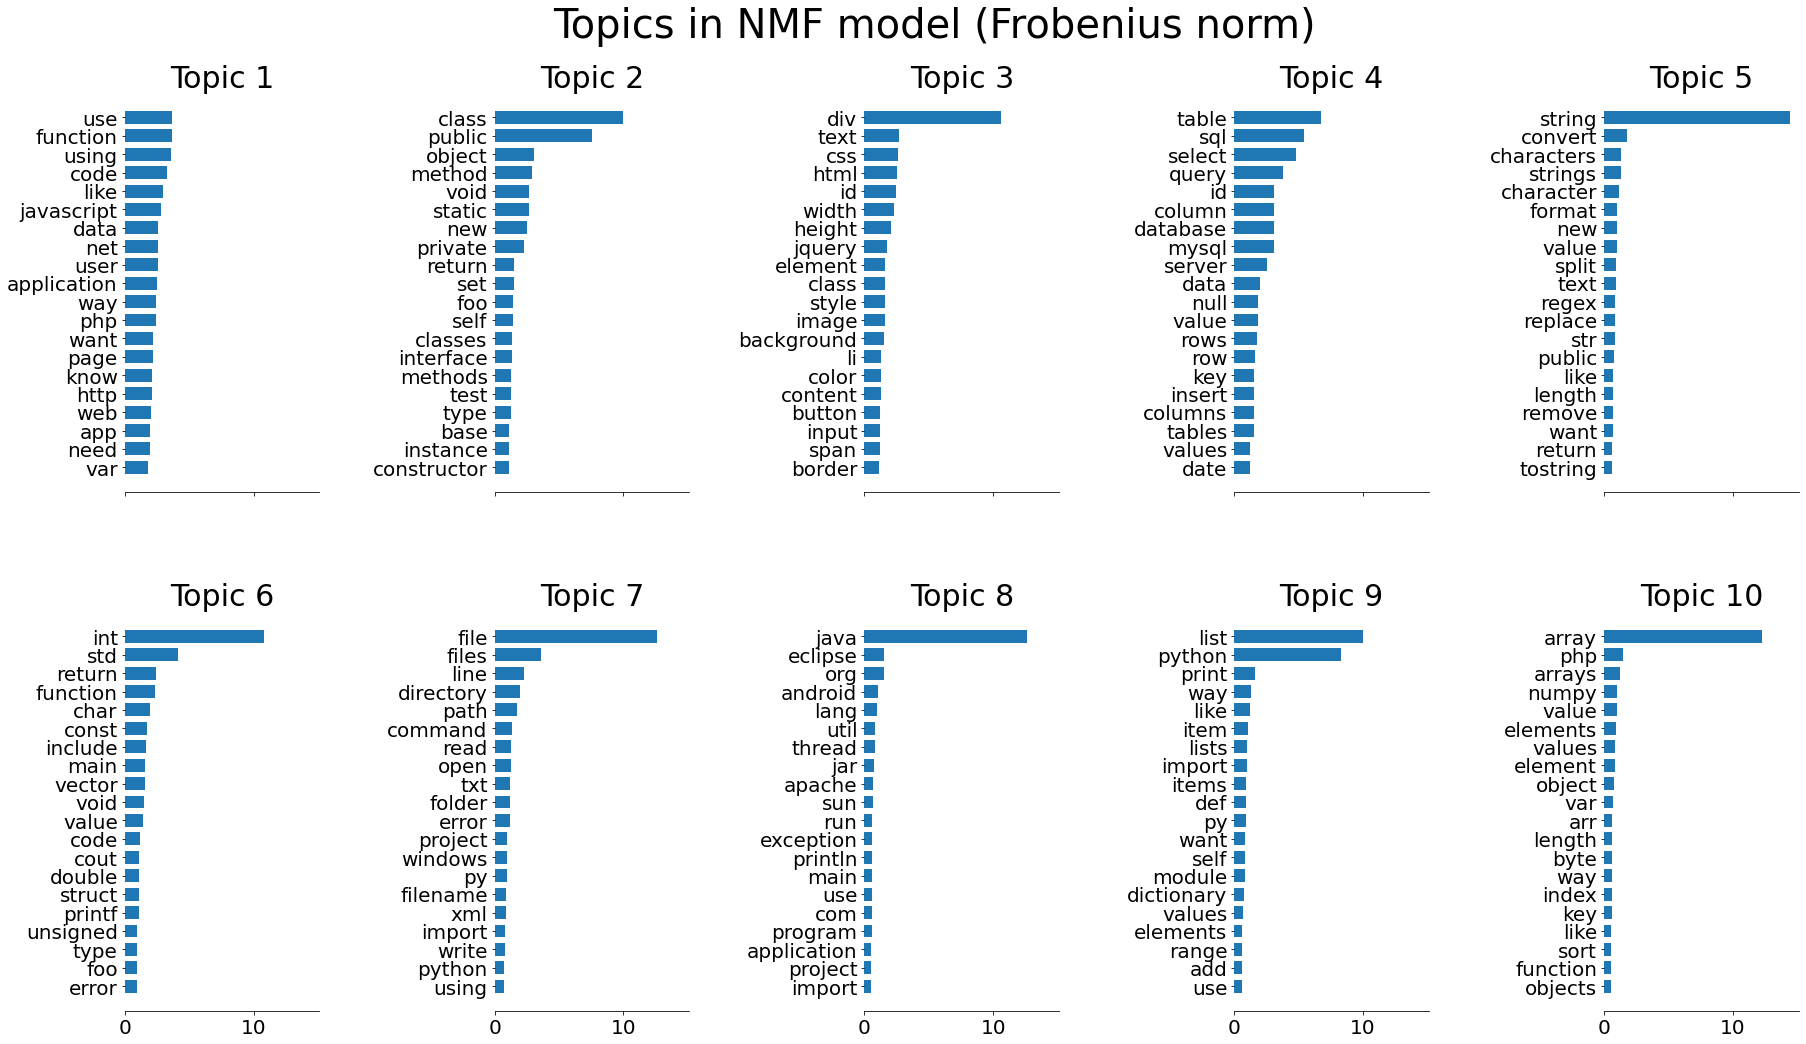

In [55]:
n_features = 1000
n_components = 10
n_top_words = 20

tfidf = pickle.load(open("tfidf.pkl", 'rb'))

# Fitting the NMF model (Frobenius norm) with tf-idf features, 
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = pickle.load(open("tfidf_feature_names.pkl", 'rb'))
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

Avec cette première méthode, j'identifie bien les topics 2 (java/objet), 3 (html/css), 4 (sql), 5 (strings), 7 (python/fichiers), 8 (java/android), 9 (python/structure). Il reste 3 topics sur les 10 qui sont plus "flous" à mes yeux. Il s'agit cependant d'un ressenti personnel, car j'ignore peut-être tout d'un domaine identifié par le modèle.

Par défaut, le modèle NMF utilise un critère de moindres carrés (LS ou norme de Frobenius des matrices ou “norme trace”). En ajoutant un paramètre "beta_loss", on peut utiliser la divergence de Kullback-Leibler (KL).

C:\anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


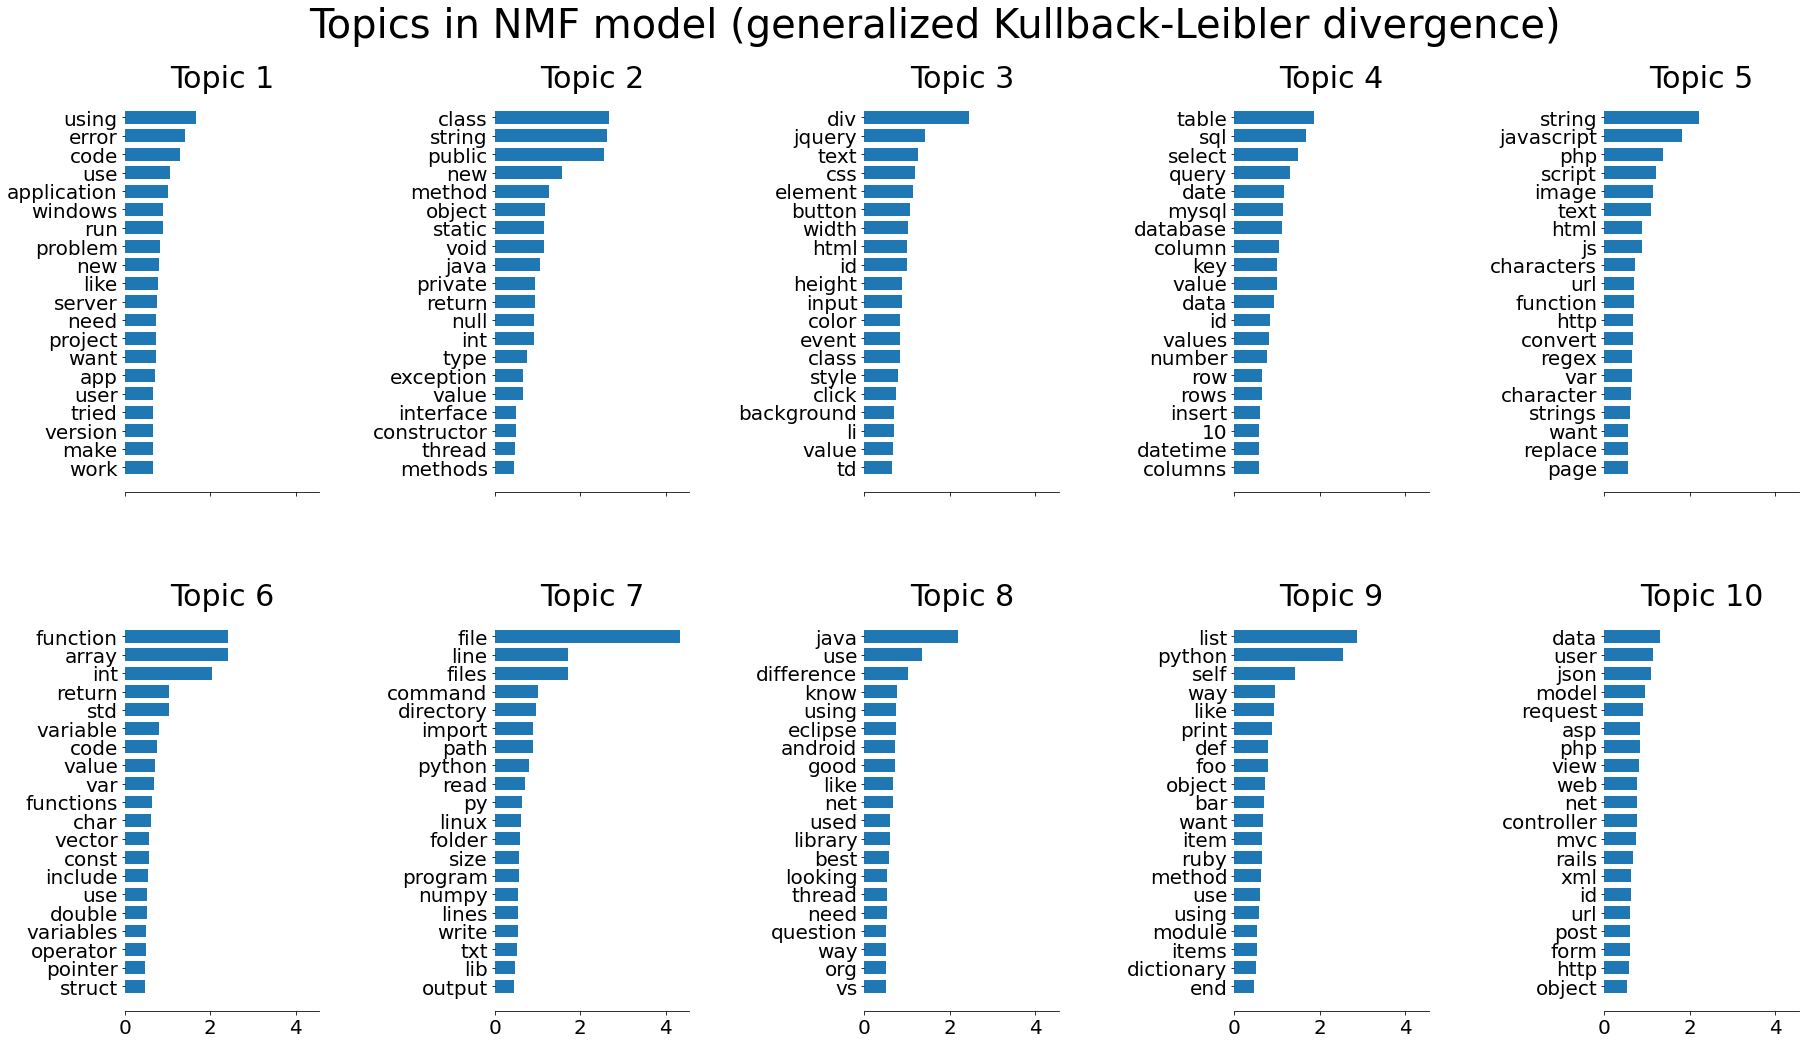

In [56]:
# Test avec la méthode NMF "kullback-leibler"
nmf_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

plot_top_words(nmf_kl, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

Avec cette deuxième méthode, j'identifie bien les topics 1 (C++/windows), 2, (java/objet), 3 (html/css), 4 (sql), 5 (html/php/js), 7 (python/fichiers), 8 (java/android), 9 (python/structure). Il reste 2 topics sur les 10 qui sont plus "flous" à mes yeux, ce qui semble être mieux que la méthode précédente.

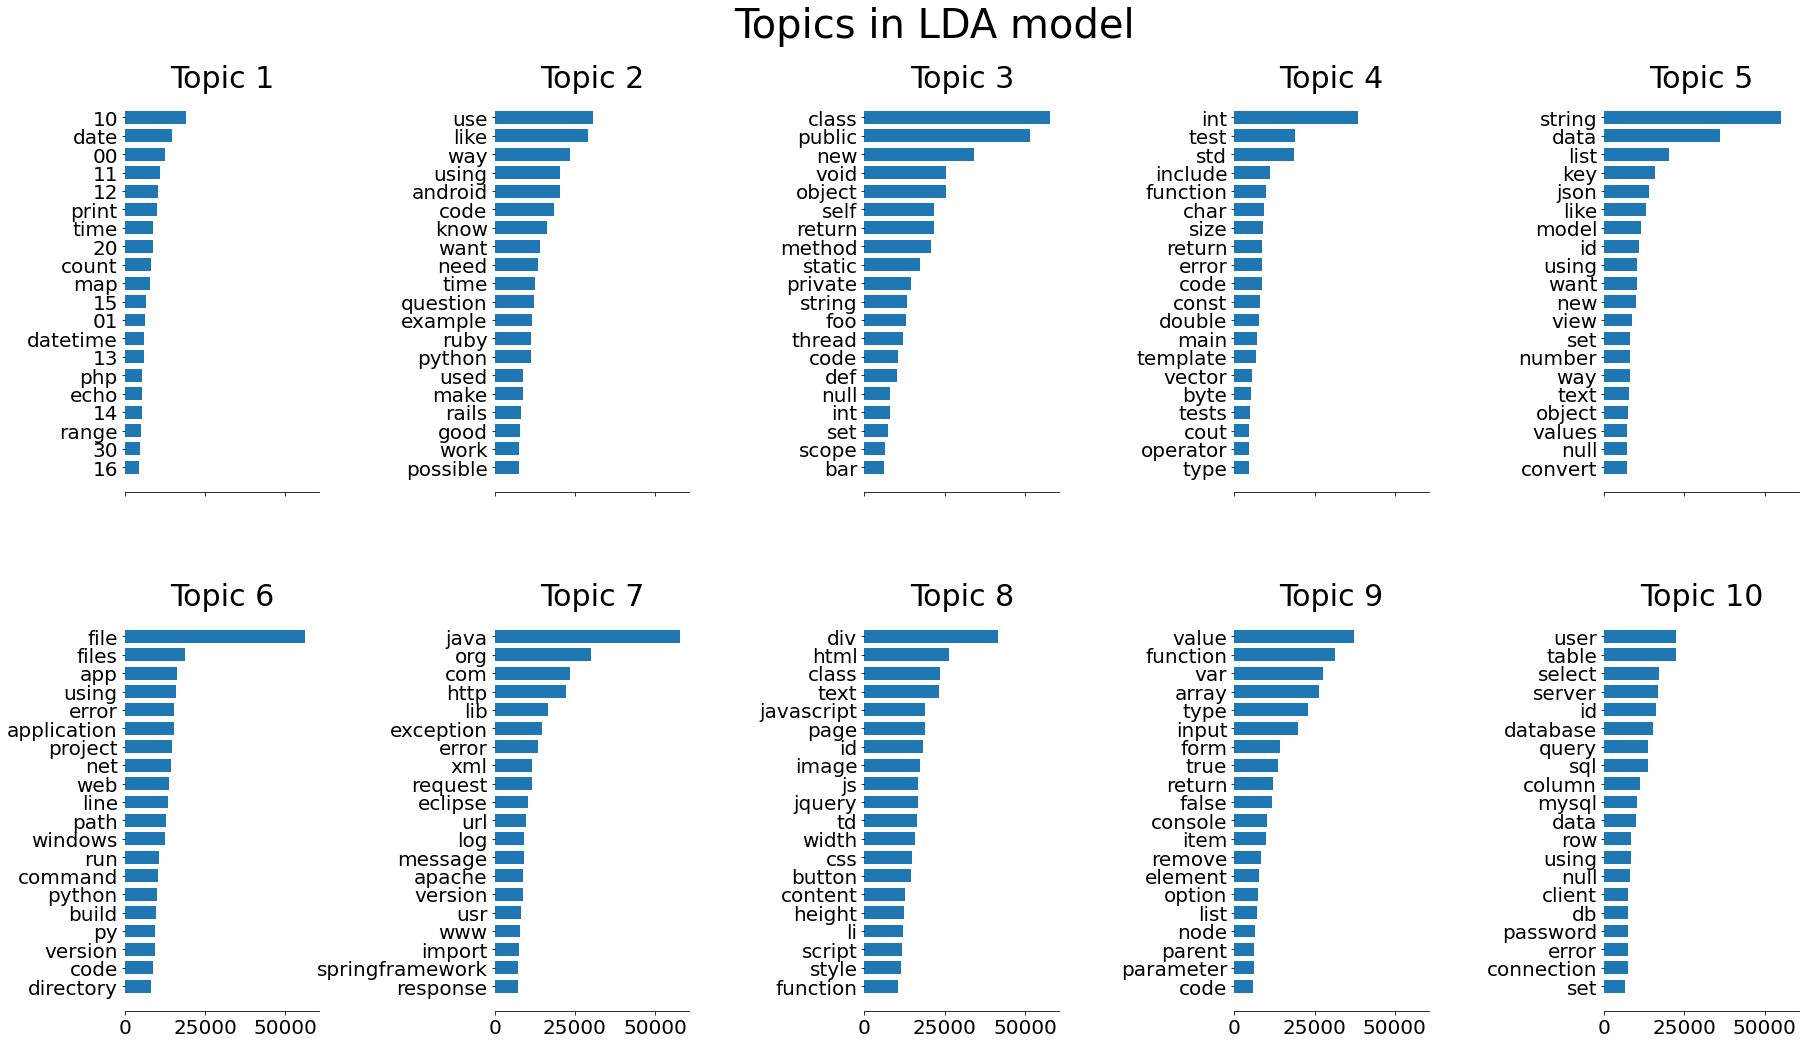

In [53]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
tf = pickle.load(open("tf.pkl", 'rb'))
lda.fit(tf)
tf_feature_names = pickle.load(open("tf_feature_names.pkl", 'rb'))
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

Avec cette troisième méthode, j'identifie les topics 6 (python/windows), 7 (java), 8 (html/js), 9 (js), 10 (sql). Il reste 5 topics sur les 10 qui sont plus "flous" à mes yeux, ce qui semble être moins bien que les deux méthodes précédentes.

Pour obtenir des scores plus fiables que mes premières impressions, j'utilise une librairie : "Gensim" qui permet le calcul d'un score de cohérence. Par contre, cela implique de refaire le calcul des modèles via cette librairie.

Source : https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

In [14]:
# Lecture du CSV
df = pd.read_csv('txt_and_tags.csv')
# petit contournement de l'erreur d'avoir sauvegardé en texte
df['txt'] = [txt.replace("['", "").replace("']", "").split("', '") for txt in df['txt']]

In [15]:
dictionary = Dictionary(df['txt'])
corpus = [dictionary.doc2bow(txt) for txt in df['txt']]
nmf = Nmf(corpus, num_topics=n_components, id2word=dictionary)

NameError: name 'n_components' is not defined

In [98]:
cm_nmf = CoherenceModel(
    model=nmf,
    texts=df['txt'],
    dictionary=dictionary,
    coherence='c_v'
)

0.5098127309587661

In [99]:
print("Score de cohérence du modèle NMF :", cm_nmf.get_coherence())

Score de cohérence du modèle NMF : 0.5098127309587661


In [101]:
lda = LdaModel(corpus, num_topics=n_components, id2word=dictionary)

In [102]:
cm_lda = CoherenceModel(
    model=lda,
    texts=df['txt'],
    dictionary=dictionary,
    coherence='c_v'
)

In [103]:
print("Score de cohérence du modèle LDA :", cm_lda.get_coherence())

Score de cohérence du modèle LDA : 0.5942911272076538


On constate donc que le modèle LDA obtient un meilleur score de cohérence que le NMF ! Cela va à l'encontre de mon intuition initiale, mais les chiffres parlent d'eux-mêmes.

Je cherche maintenant à déterminer si mon choix du nombre de topics (10) était adapté, en testant différentes valeurs.

In [13]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 15, 1))
for i in np.arange(15, 75 + 1, 5):
    topic_nums.append(i)
print(topic_nums)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


In [17]:
# Run the nmf & lda models and calculate the coherence
# score for each number of topics
coherence_scores_nmf = []
coherence_scores_lda = []

for n in topic_nums:
    print("... n =", n)
    nmf = Nmf(corpus, num_topics=n, id2word=dictionary)
    cm_nmf = CoherenceModel(
        model=nmf,
        texts=df['txt'],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores_nmf.append(round(cm_nmf.get_coherence(), 5))
    lda = LdaModel(corpus, num_topics=n, id2word=dictionary)
    cm_lda = CoherenceModel(
        model=lda,
        texts=df['txt'],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores_lda.append(round(cm_lda.get_coherence(), 5))

... n = 5
... n = 6
... n = 7
... n = 8
... n = 9
... n = 10
... n = 11
... n = 12
... n = 13
... n = 14
... n = 15
... n = 20
... n = 25
... n = 30
... n = 35
... n = 40
... n = 45
... n = 50
... n = 55
... n = 60
... n = 65
... n = 70
... n = 75


In [ ]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()